# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

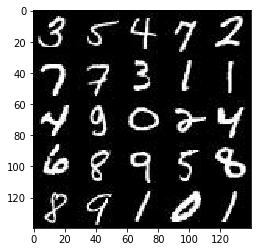

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

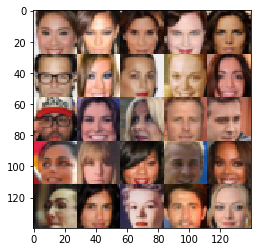

In [3]:
show_n_images = 25

import helper
import os
from glob import glob
from matplotlib import pyplot

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/home/ablecao/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape = (None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, shape = (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def lrelu(bn, alpha=0.1):
    return tf.maximum(alpha * bn, bn)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = lrelu(bn1)
        # 16x16x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = lrelu(bn2)
        # 8x8x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        do3 = tf.nn.dropout(x3, 0.8)
        bn3 = tf.layers.batch_normalization(do3, training=True)
        relu3 = lrelu(bn3)
        # 4x4x512

        # Flatten it
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.2
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)

        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = lrelu(x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, kernel_size=5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = lrelu(x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = lrelu(x3)
        # 28x28x128 now
        
        # Output layer
        out = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', activation=tf.tanh)
        # 28x28x3 now
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    label_smoothness = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-label_smoothness)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1, beta2=0.9).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1, beta2=0.9).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height,image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    is_train = tf.placeholder(tf.bool)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, 
                                                     input_z: batch_z,
                                                     lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,
                                                    input_real: batch_images,
                                                    lr: learning_rate})
                
                # Print the generator output every 100 batches
                if (steps % 100 == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
            
            # At the end of each epoch, get the losses and print them out
            train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
            train_loss_g = g_loss.eval({input_z: batch_z})
                
            print("Epoch {}/{}...".format(e+1, epochs),
                  "Discriminator Loss: {:.4f}...".format(train_loss_d),
                  "Generator Loss: {:.4f}".format(train_loss_g))    

            # Save losses to view after training
            losses.append((train_loss_d, train_loss_g))
            
            # Sample from generator as we're training for viewing afterwards
            sample_z = np.random.uniform(-1, 1, size=(16, z_dim))
            gen_samples = sess.run(
                           generator(input_z, image_channels, is_train=False),
                           feed_dict={input_z: sample_z})
            samples.append(gen_samples)
   
                
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

In [ ]:
from glob import glob
import os
import tensorflow as tf


batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

()
('Epoch 1/1...', 'Discriminator Loss: 0.6724...', 'Generator Loss: 4.9385')
('Epoch 1/1...', 'Discriminator Loss: 0.5760...', 'Generator Loss: 3.2759')
('Epoch 1/1...', 'Discriminator Loss: 2.3236...', 'Generator Loss: 0.3888')
('Epoch 1/1...', 'Discriminator Loss: 1.9224...', 'Generator Loss: 6.5807')
('Epoch 1/1...', 'Discriminator Loss: 0.4241...', 'Generator Loss: 3.6242')
('Epoch 1/1...', 'Discriminator Loss: 0.4321...', 'Generator Loss: 4.7301')
('Epoch 1/1...', 'Discriminator Loss: 0.6030...', 'Generator Loss: 2.6292')
('Epoch 1/1...', 'Discriminator Loss: 1.1068...', 'Generator Loss: 1.0602')
('Epoch 1/1...', 'Discriminator Loss: 1.4908...', 'Generator Loss: 3.5635')
('Epoch 1/1...', 'Discriminator Loss: 1.3048...', 'Generator Loss: 0.6607')


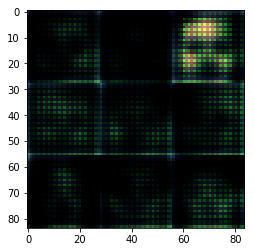

('Epoch 1/1...', 'Discriminator Loss: 0.9371...', 'Generator Loss: 1.8366')
('Epoch 1/1...', 'Discriminator Loss: 1.4084...', 'Generator Loss: 0.5440')
('Epoch 1/1...', 'Discriminator Loss: 1.0383...', 'Generator Loss: 0.9561')
('Epoch 1/1...', 'Discriminator Loss: 2.4084...', 'Generator Loss: 0.2159')
('Epoch 1/1...', 'Discriminator Loss: 1.7664...', 'Generator Loss: 3.8320')
('Epoch 1/1...', 'Discriminator Loss: 1.3574...', 'Generator Loss: 0.6813')
('Epoch 1/1...', 'Discriminator Loss: 1.1913...', 'Generator Loss: 4.3231')
('Epoch 1/1...', 'Discriminator Loss: 0.4165...', 'Generator Loss: 2.9370')
('Epoch 1/1...', 'Discriminator Loss: 0.6041...', 'Generator Loss: 1.8865')
('Epoch 1/1...', 'Discriminator Loss: 0.9765...', 'Generator Loss: 1.9778')


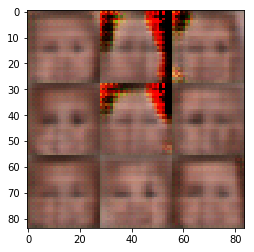

('Epoch 1/1...', 'Discriminator Loss: 0.4643...', 'Generator Loss: 2.6484')
('Epoch 1/1...', 'Discriminator Loss: 1.1747...', 'Generator Loss: 0.6575')
('Epoch 1/1...', 'Discriminator Loss: 1.6277...', 'Generator Loss: 0.5370')
('Epoch 1/1...', 'Discriminator Loss: 0.6205...', 'Generator Loss: 1.8719')
('Epoch 1/1...', 'Discriminator Loss: 1.6580...', 'Generator Loss: 3.7353')
('Epoch 1/1...', 'Discriminator Loss: 0.4393...', 'Generator Loss: 3.0698')
('Epoch 1/1...', 'Discriminator Loss: 0.7080...', 'Generator Loss: 2.3716')
('Epoch 1/1...', 'Discriminator Loss: 0.6990...', 'Generator Loss: 2.7993')
('Epoch 1/1...', 'Discriminator Loss: 0.4371...', 'Generator Loss: 2.6455')
('Epoch 1/1...', 'Discriminator Loss: 0.6376...', 'Generator Loss: 3.4362')


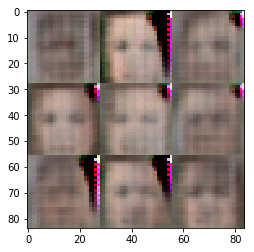

('Epoch 1/1...', 'Discriminator Loss: 0.7556...', 'Generator Loss: 2.1963')
('Epoch 1/1...', 'Discriminator Loss: 0.9446...', 'Generator Loss: 1.0127')
('Epoch 1/1...', 'Discriminator Loss: 0.6240...', 'Generator Loss: 2.2964')
('Epoch 1/1...', 'Discriminator Loss: 0.5844...', 'Generator Loss: 1.8605')
('Epoch 1/1...', 'Discriminator Loss: 1.3653...', 'Generator Loss: 3.3926')
('Epoch 1/1...', 'Discriminator Loss: 2.7824...', 'Generator Loss: 6.3816')
('Epoch 1/1...', 'Discriminator Loss: 0.8655...', 'Generator Loss: 4.1007')
('Epoch 1/1...', 'Discriminator Loss: 0.4105...', 'Generator Loss: 3.0355')
('Epoch 1/1...', 'Discriminator Loss: 1.0906...', 'Generator Loss: 1.0737')
('Epoch 1/1...', 'Discriminator Loss: 0.4505...', 'Generator Loss: 2.8524')


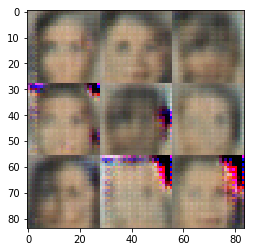

('Epoch 1/1...', 'Discriminator Loss: 0.5803...', 'Generator Loss: 2.4968')
('Epoch 1/1...', 'Discriminator Loss: 0.4372...', 'Generator Loss: 3.1663')
('Epoch 1/1...', 'Discriminator Loss: 0.5578...', 'Generator Loss: 2.4658')
('Epoch 1/1...', 'Discriminator Loss: 0.7197...', 'Generator Loss: 1.7433')
('Epoch 1/1...', 'Discriminator Loss: 0.6926...', 'Generator Loss: 2.9467')
('Epoch 1/1...', 'Discriminator Loss: 2.6642...', 'Generator Loss: 6.8210')
('Epoch 1/1...', 'Discriminator Loss: 0.6492...', 'Generator Loss: 2.2339')
('Epoch 1/1...', 'Discriminator Loss: 1.5091...', 'Generator Loss: 0.5156')
('Epoch 1/1...', 'Discriminator Loss: 0.5426...', 'Generator Loss: 2.0702')
('Epoch 1/1...', 'Discriminator Loss: 1.0196...', 'Generator Loss: 4.0084')


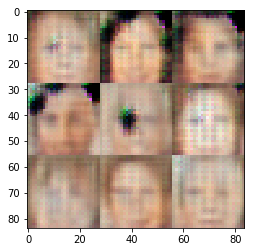

('Epoch 1/1...', 'Discriminator Loss: 1.3634...', 'Generator Loss: 2.9526')
('Epoch 1/1...', 'Discriminator Loss: 1.0765...', 'Generator Loss: 3.2103')
('Epoch 1/1...', 'Discriminator Loss: 0.5149...', 'Generator Loss: 3.2577')
('Epoch 1/1...', 'Discriminator Loss: 1.8729...', 'Generator Loss: 3.2459')
('Epoch 1/1...', 'Discriminator Loss: 0.5070...', 'Generator Loss: 2.9259')
('Epoch 1/1...', 'Discriminator Loss: 0.4015...', 'Generator Loss: 3.8824')
('Epoch 1/1...', 'Discriminator Loss: 1.5907...', 'Generator Loss: 1.6484')
('Epoch 1/1...', 'Discriminator Loss: 2.1085...', 'Generator Loss: 0.3138')
('Epoch 1/1...', 'Discriminator Loss: 0.5007...', 'Generator Loss: 2.4660')
('Epoch 1/1...', 'Discriminator Loss: 1.2632...', 'Generator Loss: 0.6084')


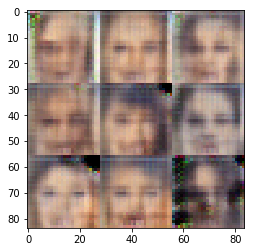

('Epoch 1/1...', 'Discriminator Loss: 0.6890...', 'Generator Loss: 3.1825')
('Epoch 1/1...', 'Discriminator Loss: 0.4469...', 'Generator Loss: 2.6299')
('Epoch 1/1...', 'Discriminator Loss: 0.4146...', 'Generator Loss: 3.0536')
('Epoch 1/1...', 'Discriminator Loss: 0.6444...', 'Generator Loss: 6.8855')
('Epoch 1/1...', 'Discriminator Loss: 0.3784...', 'Generator Loss: 4.3967')
('Epoch 1/1...', 'Discriminator Loss: 0.3984...', 'Generator Loss: 3.1510')
('Epoch 1/1...', 'Discriminator Loss: 1.6756...', 'Generator Loss: 0.3941')
('Epoch 1/1...', 'Discriminator Loss: 3.4828...', 'Generator Loss: 0.0719')
('Epoch 1/1...', 'Discriminator Loss: 0.5470...', 'Generator Loss: 2.4394')
('Epoch 1/1...', 'Discriminator Loss: 0.4806...', 'Generator Loss: 2.9067')


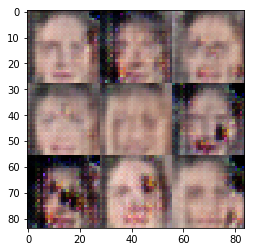

('Epoch 1/1...', 'Discriminator Loss: 1.1163...', 'Generator Loss: 0.8264')
('Epoch 1/1...', 'Discriminator Loss: 0.5292...', 'Generator Loss: 2.3411')
('Epoch 1/1...', 'Discriminator Loss: 0.5060...', 'Generator Loss: 2.8471')
('Epoch 1/1...', 'Discriminator Loss: 0.8865...', 'Generator Loss: 1.3872')
('Epoch 1/1...', 'Discriminator Loss: 1.8723...', 'Generator Loss: 6.2780')
('Epoch 1/1...', 'Discriminator Loss: 0.4955...', 'Generator Loss: 2.3850')
('Epoch 1/1...', 'Discriminator Loss: 1.3137...', 'Generator Loss: 0.7004')
('Epoch 1/1...', 'Discriminator Loss: 1.0055...', 'Generator Loss: 1.2657')
('Epoch 1/1...', 'Discriminator Loss: 1.8255...', 'Generator Loss: 0.4392')
('Epoch 1/1...', 'Discriminator Loss: 0.8748...', 'Generator Loss: 1.2494')


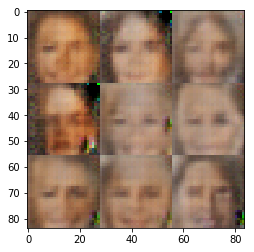

('Epoch 1/1...', 'Discriminator Loss: 0.6959...', 'Generator Loss: 2.3825')
('Epoch 1/1...', 'Discriminator Loss: 2.4235...', 'Generator Loss: 4.6885')
('Epoch 1/1...', 'Discriminator Loss: 0.4192...', 'Generator Loss: 3.9271')
('Epoch 1/1...', 'Discriminator Loss: 0.8367...', 'Generator Loss: 4.6683')
('Epoch 1/1...', 'Discriminator Loss: 0.4878...', 'Generator Loss: 4.9399')
('Epoch 1/1...', 'Discriminator Loss: 2.2953...', 'Generator Loss: 6.6741')
('Epoch 1/1...', 'Discriminator Loss: 0.4874...', 'Generator Loss: 3.2696')
('Epoch 1/1...', 'Discriminator Loss: 0.5560...', 'Generator Loss: 3.6259')
('Epoch 1/1...', 'Discriminator Loss: 0.5802...', 'Generator Loss: 2.2877')
('Epoch 1/1...', 'Discriminator Loss: 0.5416...', 'Generator Loss: 2.0766')


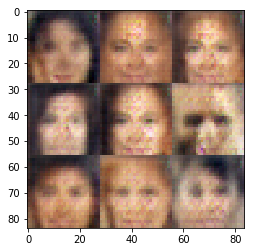

('Epoch 1/1...', 'Discriminator Loss: 1.0521...', 'Generator Loss: 0.8577')
('Epoch 1/1...', 'Discriminator Loss: 0.9173...', 'Generator Loss: 1.0615')
('Epoch 1/1...', 'Discriminator Loss: 0.6696...', 'Generator Loss: 4.4695')
('Epoch 1/1...', 'Discriminator Loss: 0.4775...', 'Generator Loss: 3.9063')
('Epoch 1/1...', 'Discriminator Loss: 0.9526...', 'Generator Loss: 1.3538')
('Epoch 1/1...', 'Discriminator Loss: 0.5405...', 'Generator Loss: 2.0545')
('Epoch 1/1...', 'Discriminator Loss: 0.4050...', 'Generator Loss: 3.8158')
('Epoch 1/1...', 'Discriminator Loss: 0.4337...', 'Generator Loss: 2.6883')
('Epoch 1/1...', 'Discriminator Loss: 0.9202...', 'Generator Loss: 1.1251')
('Epoch 1/1...', 'Discriminator Loss: 0.5084...', 'Generator Loss: 3.0905')


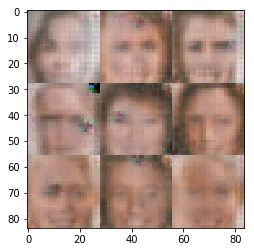

('Epoch 1/1...', 'Discriminator Loss: 0.6840...', 'Generator Loss: 3.0361')
('Epoch 1/1...', 'Discriminator Loss: 2.1978...', 'Generator Loss: 5.1386')
('Epoch 1/1...', 'Discriminator Loss: 0.4381...', 'Generator Loss: 3.1071')
('Epoch 1/1...', 'Discriminator Loss: 0.6994...', 'Generator Loss: 2.0628')
('Epoch 1/1...', 'Discriminator Loss: 0.8309...', 'Generator Loss: 1.1057')
('Epoch 1/1...', 'Discriminator Loss: 0.6411...', 'Generator Loss: 1.8458')
('Epoch 1/1...', 'Discriminator Loss: 0.8058...', 'Generator Loss: 1.4373')
('Epoch 1/1...', 'Discriminator Loss: 0.5287...', 'Generator Loss: 2.2927')
('Epoch 1/1...', 'Discriminator Loss: 0.4707...', 'Generator Loss: 2.6818')
('Epoch 1/1...', 'Discriminator Loss: 1.2497...', 'Generator Loss: 0.7536')


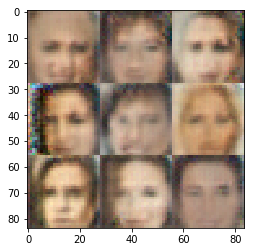

('Epoch 1/1...', 'Discriminator Loss: 0.3974...', 'Generator Loss: 3.7380')
('Epoch 1/1...', 'Discriminator Loss: 0.9920...', 'Generator Loss: 5.9548')
('Epoch 1/1...', 'Discriminator Loss: 0.8003...', 'Generator Loss: 1.8373')
('Epoch 1/1...', 'Discriminator Loss: 0.7188...', 'Generator Loss: 1.7448')
('Epoch 1/1...', 'Discriminator Loss: 1.5450...', 'Generator Loss: 2.2236')
('Epoch 1/1...', 'Discriminator Loss: 3.0914...', 'Generator Loss: 4.4538')
('Epoch 1/1...', 'Discriminator Loss: 0.6371...', 'Generator Loss: 1.7040')
('Epoch 1/1...', 'Discriminator Loss: 0.6102...', 'Generator Loss: 1.8074')
('Epoch 1/1...', 'Discriminator Loss: 3.0980...', 'Generator Loss: 6.9885')
('Epoch 1/1...', 'Discriminator Loss: 1.7353...', 'Generator Loss: 0.4266')


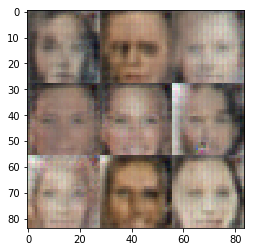

('Epoch 1/1...', 'Discriminator Loss: 1.3938...', 'Generator Loss: 2.9639')
('Epoch 1/1...', 'Discriminator Loss: 1.5728...', 'Generator Loss: 1.6632')
('Epoch 1/1...', 'Discriminator Loss: 1.6968...', 'Generator Loss: 0.6813')
('Epoch 1/1...', 'Discriminator Loss: 1.5630...', 'Generator Loss: 0.5210')
('Epoch 1/1...', 'Discriminator Loss: 1.6074...', 'Generator Loss: 0.5355')
('Epoch 1/1...', 'Discriminator Loss: 1.5715...', 'Generator Loss: 0.8550')
('Epoch 1/1...', 'Discriminator Loss: 1.3450...', 'Generator Loss: 0.9621')
('Epoch 1/1...', 'Discriminator Loss: 1.3048...', 'Generator Loss: 0.9198')
('Epoch 1/1...', 'Discriminator Loss: 1.3782...', 'Generator Loss: 0.9440')
('Epoch 1/1...', 'Discriminator Loss: 1.5407...', 'Generator Loss: 0.5030')


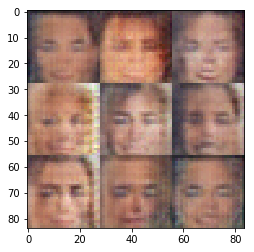

('Epoch 1/1...', 'Discriminator Loss: 2.3768...', 'Generator Loss: 0.1702')
('Epoch 1/1...', 'Discriminator Loss: 1.3613...', 'Generator Loss: 0.9739')
('Epoch 1/1...', 'Discriminator Loss: 1.6419...', 'Generator Loss: 0.5403')
('Epoch 1/1...', 'Discriminator Loss: 1.4026...', 'Generator Loss: 1.0249')
('Epoch 1/1...', 'Discriminator Loss: 2.0270...', 'Generator Loss: 0.2676')
('Epoch 1/1...', 'Discriminator Loss: 1.4612...', 'Generator Loss: 0.5902')
('Epoch 1/1...', 'Discriminator Loss: 1.7186...', 'Generator Loss: 1.2960')
('Epoch 1/1...', 'Discriminator Loss: 1.7761...', 'Generator Loss: 0.3591')
('Epoch 1/1...', 'Discriminator Loss: 1.4739...', 'Generator Loss: 0.9904')
('Epoch 1/1...', 'Discriminator Loss: 1.4125...', 'Generator Loss: 0.9284')


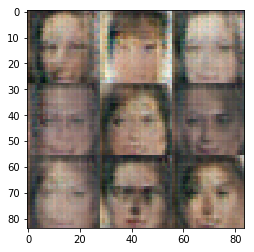

('Epoch 1/1...', 'Discriminator Loss: 1.3311...', 'Generator Loss: 0.8561')
('Epoch 1/1...', 'Discriminator Loss: 1.7374...', 'Generator Loss: 1.3542')
('Epoch 1/1...', 'Discriminator Loss: 1.3699...', 'Generator Loss: 0.6723')
('Epoch 1/1...', 'Discriminator Loss: 1.4998...', 'Generator Loss: 1.2000')
('Epoch 1/1...', 'Discriminator Loss: 1.3938...', 'Generator Loss: 0.7157')
('Epoch 1/1...', 'Discriminator Loss: 1.2909...', 'Generator Loss: 0.7176')
('Epoch 1/1...', 'Discriminator Loss: 1.5667...', 'Generator Loss: 0.7746')
('Epoch 1/1...', 'Discriminator Loss: 1.5021...', 'Generator Loss: 0.6063')
('Epoch 1/1...', 'Discriminator Loss: 1.4783...', 'Generator Loss: 0.5600')
('Epoch 1/1...', 'Discriminator Loss: 1.5602...', 'Generator Loss: 0.4628')


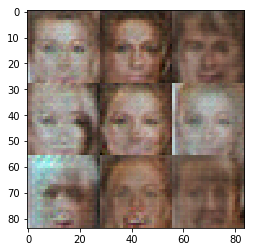

('Epoch 1/1...', 'Discriminator Loss: 1.3170...', 'Generator Loss: 0.7068')
('Epoch 1/1...', 'Discriminator Loss: 1.9728...', 'Generator Loss: 2.0067')
('Epoch 1/1...', 'Discriminator Loss: 1.3663...', 'Generator Loss: 0.7700')
('Epoch 1/1...', 'Discriminator Loss: 1.3990...', 'Generator Loss: 1.2634')
('Epoch 1/1...', 'Discriminator Loss: 1.3472...', 'Generator Loss: 0.8280')
('Epoch 1/1...', 'Discriminator Loss: 1.5198...', 'Generator Loss: 1.0251')
('Epoch 1/1...', 'Discriminator Loss: 1.3832...', 'Generator Loss: 1.0248')
('Epoch 1/1...', 'Discriminator Loss: 1.3311...', 'Generator Loss: 1.1586')


In [13]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。